# Deep Learning (RNN-LSTM)

## Bibliotheken importieren:

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM
import datetime as datetime
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

## Vorbereitung der Daten:

In [2]:
df = pd.read_csv('cleanbooksdata.csv')[['rating', 'num_ratings', 'price', 'type', 'date']]
df

,rating,num_ratings,price,type,date
0,4.7,67538.0,20.41,Taschenbuch,10. Dezember 2018
1,4.5,8627.0,11.49,Gebundenes Buch,5. Februar 2013
2,4.5,99055.0,12.44,Taschenbuch,13. September 2016
3,4.6,33078.0,11.49,Taschenbuch,10. Mai 2012
4,4.6,22039.0,5.69,Taschenbuch,23. März 2017
...,...,...,...,...,...
81,4.4,1478.0,10.54,Taschenbuch,15. April 2019
82,4.3,6049.0,1.98,Taschenbuch,29. November 2004
83,4.7,24188.0,10.24,Taschenbuch,4. Januar 2018
84,4.6,37461.0,7.77,Taschenbuch,22. Mai 2012


### Preisverteilung anzeigen:

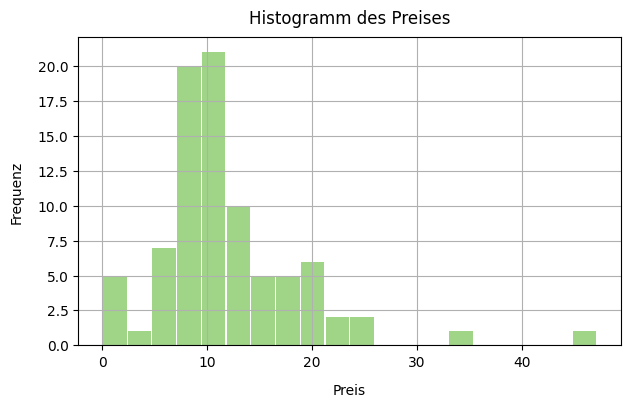

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Plot Histogram
fig = plt.figure( figsize=(7,4))
n, bins, patches = plt.hist(x=df['price'], 
                            bins=20, 
                            color='#42AD12',
                            alpha=0.5, 
                            rwidth=0.95
                   )
# Grid
plt.grid()

# Set labels
plt.xlabel('Preis', fontsize=10, labelpad=10)
plt.ylabel('Frequenz', fontsize=10, labelpad=10)
plt.title('Histogramm des Preises', fontsize=12, pad=10)

# Set fontsize of tick labels
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)

plt.show()

In [4]:
# Für die Vorhersage wird 0 und 1 für die Werte gesetzt: Taschenbuch = 0, Gebundenes Buch = 1 
df['type'] = df['type'].str.replace('Taschenbuch', '0')
df['type'] = df['type'].str.replace('Gebundenes Buch', '1')
df['booktype'] = df['type'].astype(object).astype(int)
df

,rating,num_ratings,price,type,date,booktype
0,4.7,67538.0,20.41,0,10. Dezember 2018,0
1,4.5,8627.0,11.49,1,5. Februar 2013,1
2,4.5,99055.0,12.44,0,13. September 2016,0
3,4.6,33078.0,11.49,0,10. Mai 2012,0
4,4.6,22039.0,5.69,0,23. März 2017,0
...,...,...,...,...,...,...
81,4.4,1478.0,10.54,0,15. April 2019,0
82,4.3,6049.0,1.98,0,29. November 2004,0
83,4.7,24188.0,10.24,0,4. Januar 2018,0
84,4.6,37461.0,7.77,0,22. Mai 2012,0


In [5]:
# Erstellung einer Liste mit den Monatsnamen auf Deutsch:
month_names = ['Januar', 'Februar', 'März', 'April', 'Mai', 'Juni', 
               'Juli', 'August', 'September', 'Oktober', 'November', 'Dezember']

# Definieren einer Funktion zum Konvertieren der deutschen Datumszeichenfolge in ein Datetime-Objekt:
def german_date_to_datetime(date_string):
    # die Datumszeichenfolge auf Tag, Monat und Jahr aufteilen:
        day, month_name, year = date_string.split()
    # Entfernung aller nachgestellten Punkte aus der Tageskomponente:
        day = day.rstrip('.')
    # Konvertieren der Monatsnamen in die entsprechende Monatsnummer:
        month = month_names.index(month_name) + 1
    # Erstellung von einem Datetime-Objekt aus dem Tag, Monat und Jahr:
        return datetime.datetime(int(year), month, int(day))
        

# Anwendung der Funktion auf die Spalte „datum“ des DataFrame: 
df['date'] = df['date'].apply(german_date_to_datetime)

In [6]:
df['date'] = df['date'].dt.year
df

,rating,num_ratings,price,type,date,booktype
0,4.7,67538.0,20.41,0,2018,0
1,4.5,8627.0,11.49,1,2013,1
2,4.5,99055.0,12.44,0,2016,0
3,4.6,33078.0,11.49,0,2012,0
4,4.6,22039.0,5.69,0,2017,0
...,...,...,...,...,...,...
81,4.4,1478.0,10.54,0,2019,0
82,4.3,6049.0,1.98,0,2004,0
83,4.7,24188.0,10.24,0,2018,0
84,4.6,37461.0,7.77,0,2012,0


In [7]:
df['age'] = 2023 - (df['date'])
df = df.drop(['date'], axis=1)
df

,rating,num_ratings,price,type,booktype,age
0,4.7,67538.0,20.41,0,0,5
1,4.5,8627.0,11.49,1,1,10
2,4.5,99055.0,12.44,0,0,7
3,4.6,33078.0,11.49,0,0,11
4,4.6,22039.0,5.69,0,0,6
...,...,...,...,...,...,...
81,4.4,1478.0,10.54,0,0,4
82,4.3,6049.0,1.98,0,0,19
83,4.7,24188.0,10.24,0,0,5
84,4.6,37461.0,7.77,0,0,11


In [8]:
# Aufzeigen der ersten 5 Zeilen des DataFrame
print(df.head())

   rating  num_ratings  price type  booktype  age
0     4.7      67538.0  20.41    0         0    5
1     4.5       8627.0  11.49    1         1   10
2     4.5      99055.0  12.44    0         0    7
3     4.6      33078.0  11.49    0         0   11
4     4.6      22039.0   5.69    0         0    6


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86 entries, 0 to 85
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   rating       86 non-null     float64
 1   num_ratings  86 non-null     float64
 2   price        86 non-null     float64
 3   type         86 non-null     object 
 4   booktype     86 non-null     int32  
 5   age          86 non-null     int64  
dtypes: float64(3), int32(1), int64(1), object(1)
memory usage: 3.8+ KB


## Extrahieren der Eingabe- und Ausgabevariablen aus dem DataFrame:

In [10]:
# Extrahieren der Input Daten:
X = df[['rating', 'num_ratings', 'booktype', 'age']].values
X[:5,]

array([[4.7000e+00, 6.7538e+04, 0.0000e+00, 5.0000e+00],
       [4.5000e+00, 8.6270e+03, 1.0000e+00, 1.0000e+01],
       [4.5000e+00, 9.9055e+04, 0.0000e+00, 7.0000e+00],
       [4.6000e+00, 3.3078e+04, 0.0000e+00, 1.1000e+01],
       [4.6000e+00, 2.2039e+04, 0.0000e+00, 6.0000e+00]])

In [11]:
# Extrahieren der Output Daten
y = df['price'].values
y[:5]

array([20.41, 11.49, 12.44, 11.49,  5.69])

## Re-Scaling:

In [12]:
# Daten neu skalieren
X_scaler = MinMaxScaler()
X = X_scaler.fit_transform(X)

y_scaler = MinMaxScaler()
y = y_scaler.fit_transform(y.reshape(-1, 1))

print(X[:10])
print('------------------')
print(y[:10])

[[0.85714286 0.15533067 0.         0.06666667]
 [0.57142857 0.01915773 1.         0.23333333]
 [0.57142857 0.2281823  0.         0.13333333]
 [0.71428571 0.07567629 0.         0.26666667]
 [0.71428571 0.05015961 0.         0.1       ]
 [0.85714286 0.00760022 0.         0.13333333]
 [0.57142857 0.05273462 0.         0.13333333]
 [0.71428571 0.21993948 0.         0.33333333]
 [0.85714286 0.28572948 1.         0.06666667]
 [0.71428571 0.05399208 0.         0.46666667]]
------------------
[[0.4330575 ]
 [0.24379376]
 [0.26395077]
 [0.24379376]
 [0.1207299 ]
 [0.27201358]
 [0.253554  ]
 [0.00636537]
 [0.38616592]
 [0.        ]]


## Aufteilen des Datensatzes auf Trainings- und Testdaten:

In [13]:
# "Seed" für die Reprodizierbarkeit festlegen:
tf.random.set_seed(42)

# Datenaufteilung auf Training und Test
train_size = int(len(df) * 0.5)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

## LSTM-Modell erstellen:

In [14]:
# Modell erstellen
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# Modell trainieren
model.fit(X_train,
          y_train, 
          epochs=100, 
          batch_size=10, 
          verbose=1,
         ) # set verbose=0 to supress progress

Epoch 1/100
5/5 [==============================] - 2s 6ms/step - loss: 0.0795
Epoch 2/100
5/5 [==============================] - 0s 6ms/step - loss: 0.0522
Epoch 3/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0318
Epoch 4/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0212
Epoch 5/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0167
Epoch 6/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0168
Epoch 7/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0174
Epoch 8/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0170
Epoch 9/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0167
Epoch 10/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0161
Epoch 11/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0161
Epoch 12/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0161
Epoch 13/100
5/5 [==============================] - 0s 6ms/st

### Vorhersage auf Testdaten

In [15]:
# Vorhersage auf Testdaten
y_pred = model.predict(X_test, verbose=0)
y_pred

array([[0.22396322],
       [0.21459737],
       [0.24403934],
       [0.21872066],
       [0.21694517],
       [0.23184437],
       [0.21659847],
       [0.41080973],
       [0.22225879],
       [0.41299972],
       [0.4170829 ],
       [0.21801874],
       [0.22270985],
       [0.23408233],
       [0.2211441 ],
       [0.22936067],
       [0.22078393],
       [0.41067633],
       [0.21630938],
       [0.24117596],
       [0.23609489],
       [0.2112036 ],
       [0.2386671 ],
       [0.41321725],
       [0.21909837],
       [0.21589258],
       [0.22122331],
       [0.23629105],
       [0.21413524],
       [0.22375841],
       [0.22167794],
       [0.20903265],
       [0.22325043],
       [0.22101356],
       [0.21724112],
       [0.23173244],
       [0.22369   ],
       [0.21930812],
       [0.21746148],
       [0.23609816],
       [0.21394809],
       [0.22298661],
       [0.21576445]], dtype=float32)

MSE: 37.548
RMSE: 6.128


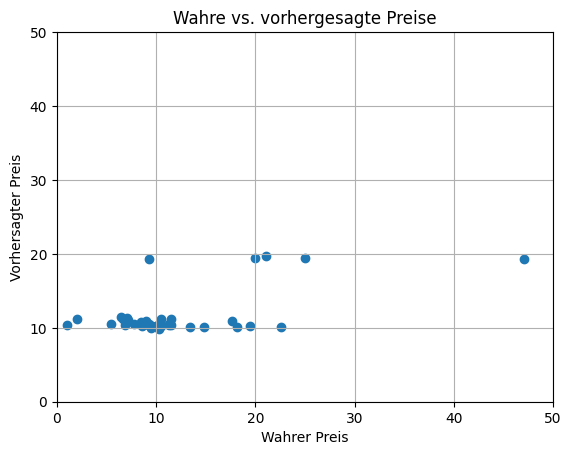

In [16]:
# Inverse Transformation der Vorhersage
y_pred_original = y_scaler.inverse_transform(y_pred)

# Inverse Transformation des Testdatensatzes
y_test_original = y_scaler.inverse_transform(y_test)

# Berechnung des SME und RMSE auf den Originaldaten
mse = mean_squared_error(y_test_original, y_pred_original)
rmse = np.sqrt(mse)
print('MSE: %.3f' % mse)
print('RMSE: %.3f' % rmse)

# Scatterplot erstellen
plt.scatter(y_test_original, y_pred_original)
plt.xlabel('Wahrer Preis')
plt.ylabel('Vorhersagter Preis')
plt.title('Wahre vs. vorhergesagte Preise')
plt.xlim(0, 50)
plt.ylim(0, 50)
plt.grid()
plt.show()